In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


In [16]:
def get_centroid_3d(v):
    return np.mean(np.where(v), axis=1)[[1,0,2]]

In [3]:
def compute_gradient(volumes, smooth_first=False):
    """
    Args:
        volumes (dict {int: 3d-array})
        smooth_first (bool): If true, smooth each volume before computing gradients. 
        This is useful if volume is binary and gradients are only nonzero at structure borders.
        
    Note:
        # 3.3 second - re-computing is much faster than loading
        # .astype(np.float32) is important;
        # Otherwise the score volume is type np.float16, np.gradient requires np.float32 and will have to convert which is very slow
        # 2s (float32) vs. 20s (float16)
    """
    gradients = {}
    for ind, v in volumes.iteritems():
        if smooth_first:
            gy_gx_gz = np.gradient(gaussian(v, 3).astype(np.float32), 3, 3, 3)
        else:
            gy_gx_gz = np.gradient(v.astype(np.float32), 3, 3, 3)
        gradients[ind] = np.array([gy_gx_gz[1], gy_gx_gz[0], gy_gx_gz[2]])
    return gradients

In [4]:
def generate_aligner_parameters(alignment_spec, structures_m=all_known_structures_sided):
    """
    Args:
        alignment_spec (dict):
        
    Returns:
        - 'volume_moving': dict {ind_m: 3d array},
        - 'volume_fixed': dict {ind_m: 3d array},
        - 'structure_to_label_moving': dict {str: int},
        - 'label_to_structure_moving': dict {int: str},
        - 'structure_to_label_fixed': dict {str: int}, 
        - 'label_to_structure_fixed': dict {int: str},
        - 'label_weights_m': dict {int: float},
        - 'label_mapping_m2f': dict {int: int},
    """
    
    stack_m_spec = alignment_spec['stack_m']
    stack_m = stack_m_spec['name']
    vol_type_m = stack_m_spec['vol_type']
    structure_m = stack_m_spec['structure']
    detector_id_m = stack_m_spec['detector_id']
    prep_id_m = stack_m_spec['prep_id']
    
    stack_f_spec = alignment_spec['stack_f']
    stack_f = stack_f_spec['name']
    vol_type_f = stack_f_spec['vol_type']
    structure_f = stack_f_spec['structure']
    detector_id_f = stack_f_spec['detector_id']
    prep_id_f = stack_f_spec['prep_id']
    
    warp_setting = alignment_spec['warp_setting']
    
    registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
    warp_properties = registration_settings.loc[warp_setting]
    print warp_properties

    ################################################################
    
    upstream_warp_setting = warp_properties['upstream_warp_id']
    if upstream_warp_setting == 'None':
        upstream_warp_setting = None
    transform_type = warp_properties['transform_type']
#     terminate_thresh = warp_properties['terminate_thresh']
    grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
#     grid_search_sample_number = warp_properties['grid_search_sample_number']
#     std_tx_um = warp_properties['std_tx_um']
#     std_ty_um = warp_properties['std_ty_um']
#     std_tz_um = warp_properties['std_tz_um']
#     std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#     std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#     std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
#     std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
#     print std_tx, std_ty, std_tz, std_theta_xy

    surround_weight = warp_properties['surround_weight']
    if isinstance(surround_weight, float) or isinstance(surround_weight, int):
        surround_weight = float(surround_weight)
        include_surround = surround_weight != 0 and not np.isnan(surround_weight)
    elif isinstance(surround_weight, str):
        surround_weight = str(surround_weight)
        # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
        include_surround = True

    print 'surround', surround_weight, include_surround

#     MAX_ITER_NUM = 1000
#     HISTORY_LEN = 20
#     lr1 = 10
#     lr2 = 0.1
    
    positive_weight = 'size'
    # positive_weight = 'inverse'
    
    ############################################################################
    
    if include_surround:
        structures_m = set(structures_m) | set([convert_to_surround_name(s, margin='200') for s in structures_m])
    
    if upstream_warp_setting is None:
        volume_moving, volume_moving_bbox_wrt_atlasSpace, structure_to_label_moving, label_to_structure_moving = \
        DataManager.load_original_volume_all_known_structures_v2(stack=stack_m, sided=True, 
                                                              volume_type=vol_type_m, 
                                                              include_surround=include_surround,
                                                                return_label_mappings=True, 
                                                                 name_or_index_as_key='index',
                                                                 common_shape=True,
                                                                structures=structures_m,
                                                                 in_bbox_wrt='atlasSpace',
                                                                    out_bbox_wrt='atlasSpace'
                                                                )
    else:
        
        initial_alignment_spec = alignment_spec['initial_alignment_spec']
        print initial_alignment_spec
        
        volume_moving, volume_moving_bbox_wrt_fixedWholebrain, structure_to_label_moving, label_to_structure_moving = \
        DataManager.load_transformed_volume_all_known_structures_v3(alignment_spec=initial_alignment_spec, 
                                                                    resolution='down32',
                                                            structures=structures_m, 
                                                            sided=True, 
                                                            return_label_mappings=True, 
                                                            name_or_index_as_key='index', 
                                                            common_shape=True,
                                                           return_origin_instead_of_bbox=False
#                                                                     in_bbox_wrt='wholebrain',
#                                                                     out_bbox_wrt='wholebrain'
                                                                )
        
    if len(volume_moving) == 0:
        sys.stderr.write("No moving volumes.\n")
    else:
        sys.stderr.write("Loaded moving volumes: %s.\n" % sorted(structure_to_label_moving.keys()))
    
    #############################################################################
        
    volume_fixed, volume_fixed_bbox_wrt_wholebrain, structure_to_label_fixed, label_to_structure_fixed = \
    DataManager.load_original_volume_all_known_structures_v2(stack=stack_f, sided=False, 
                                                          volume_type=vol_type_f,
                                                         include_surround=include_surround,
                                                         return_label_mappings=True, 
                                                             name_or_index_as_key='index',
                                                         common_shape=True,
                                                            structures=set([convert_to_unsided_label(s) 
                                                                            for s in structures_m]),
                                                            prep_id=prep_id_f,
                                                             detector_id=detector_id_f,
                                                            in_bbox_wrt='wholebrainXYcropped',
                                                            out_bbox_wrt='wholebrain')
    
    if len(volume_fixed) == 0:
        sys.stderr.write("No fixed volumes.\n")
    else:
        sys.stderr.write("Loaded fixed volumes: %s.\n" % sorted(structure_to_label_fixed.keys()))
            
    ############################################################################
    
    structure_subset_m = all_known_structures_sided

    if include_surround:
        structure_subset_m = structure_subset_m + [convert_to_surround_name(s, margin=200) for s in structure_subset_m]
    
    label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset_m and convert_to_original_name(name_m) in structure_to_label_fixed}
    
    
    if positive_weight == 'inverse' or surround_weight == 'inverse':
        t = time.time()
        cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
    #     pool = Pool(NUM_CORES)
    #     volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
    #                                              pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
    #                                                       volume_moving.keys())))
    #     pool.close()
    #     pool.join()
        volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                                 map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                          volume_moving.keys())))
        sys.stderr.write("Computing structure sizes: %.2f s\n" % (time.time() - t))

    
    label_weights_m = {}

    for label_m in label_mapping_m2f.iterkeys():
        name_m = label_to_structure_moving[label_m]
        if not is_surround_label(name_m):
            if positive_weight == 'size':
                label_weights_m[label_m] = 1.
            elif positive_weight == 'inverse':                
                p = np.percentile(volume_moving_structure_sizes.values(), 50)
                label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
            else:
                sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)

    for label_m in label_mapping_m2f.iterkeys():
        name_m = label_to_structure_moving[label_m]
        if is_surround_label(name_m):
            label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
            if surround_weight == 'inverse':
                # Note that this is positive for Stacy's data; for regular data, surround is negative
                label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
#                 label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
                label_weights_m[label_m] = surround_weight
            else:
                sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)
                
    ######################################################
    
    alinger_parameters = \
    {'label_weights_m': label_weights_m,
     'label_mapping_m2f': label_mapping_m2f,
     'volume_moving': volume_moving,
     'volume_fixed': volume_fixed,
     'structure_to_label_moving': structure_to_label_moving,
     'label_to_structure_moving': label_to_structure_moving,
     'structure_to_label_fixed': structure_to_label_fixed, 
     'label_to_structure_fixed': label_to_structure_fixed,
     'transform_type': transform_type,
     'grad_computation_sample_number': grad_computation_sample_number,
     'volume_moving_origin_wrt_wholebrain': volume_moving_bbox_wrt_atlasSpace[[0,2,4]] if upstream_warp_setting is None else volume_moving_bbox_wrt_fixedWholebrain[[0,2,4]],
     'volume_fixed_origin_wrt_wholebrain': volume_fixed_bbox_wrt_wholebrain[[0,2,4]]
    }
                
    return alinger_parameters

# Global

In [5]:
stack_m_spec = dict(name='atlasV5',
                   vol_type='score',
                   detector_id=None,
                   prep_id=None,
                   structure=None,
                   resolution='down32')

stack_f_spec = dict(name='MD585',
                   vol_type='score',
                   detector_id=15,
                   prep_id=2,
                   structure=None,
                   resolution='down32')

global_alignment_spec = dict(stack_m=stack_m_spec, 
                      stack_f=stack_f_spec,
                      warp_setting=20)

In [6]:
global_aligner_parameters = generate_aligner_parameters(alignment_spec=global_alignment_spec,
structures_m=['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '7n_L', '7n_R', 'Amb_L', 'Amb_R', 'LC_L', 'LC_R', 'LRt_L', 'LRt_R', 'Pn_L', 'Pn_R', 'Tz_L', 'Tz_R', 'VLL_L', 'VLL_R', 'RMC_L', 'RMC_R', 'SNC_L', 'SNC_R', 'SNR_L', 'SNR_R', '3N_L', '3N_R', '4N_L', '4N_R', 'Sp5C_L', 'Sp5C_R', 'PBG_L', 'PBG_R', '10N_L', '10N_R', 'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R', 'DC_L', 'DC_R', 'AP', '12N']
)

upstream_warp_id                                               None
transform_type                                               affine
terminate_thresh                                                NaN
grad_computation_sample_number                                10000
grid_search_sample_number                                       NaN
std_tx_um                                                      2000
std_ty_um                                                      2000
std_tz_um                                                      2000
std_theta_xy_degree                                              30
surround_weight                                                 NaN
regularization_weight                                           NaN
comment                           global reg no surr no grid search
max_iter_num                                                    200
Name: 20, dtype: object
surround nan False


Prior structure/index map not found. Generating a new one.
Loaded moving volumes: ['10N_L', '10N_R', '12N', '3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '7n_L', '7n_R', 'AP', 'Amb_L', 'Amb_R', 'DC_L', 'DC_R', 'LC_L', 'LC_R', 'LRt_L', 'LRt_R', 'PBG_L', 'PBG_R', 'Pn_L', 'Pn_R', 'RMC_L', 'RMC_R', 'SNC_L', 'SNC_R', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R', 'VLL_L', 'VLL_R'].
Prior structure/index map not found. Generating a new one.


rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_VCP.bp" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_VCP.bp" "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_VCP.bp"
rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_VCP_bbox.txt" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_VCP_bbox.txt" "/home/yuncong/CSHL_volu

rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_6N_bbox.txt" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_6N_bbox.txt" "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_6N_bbox.txt"
rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_SNR.bp" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_SNR.bp" "/home/yuncong/CSHL_v

Loaded fixed volumes: ['10N', '12N', '3N', '4N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'DC', 'LC', 'LRt', 'PBG', 'Pn', 'RMC', 'SNC', 'SNR', 'Sp5C', 'Tz', 'VCA', 'VCP', 'VLL'].


In [7]:
volume_fixed = global_aligner_parameters['volume_fixed']
volume_moving = global_aligner_parameters['volume_moving']

In [8]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=global_aligner_parameters['label_mapping_m2f'])

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [9]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
#                      indices_m=[aligner_parameters['structure_to_label_moving']['7N']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [ 233.   197.   206.5], centroid_f: [ 256.   187.5  184.5]


In [10]:
aligner.set_label_weights(label_weights=global_aligner_parameters['label_weights_m'])

In [11]:
gradients_f = compute_gradient(volume_fixed, smooth_first=True)
aligner.load_gradient(gradients=gradients_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])


In [12]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=global_aligner_parameters['transform_type'], 
                                     max_iter_num=300,
                                     history_len=20, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=global_aligner_parameters['grad_computation_sample_number'],
                                     lr1=1, lr2=.1,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Norm of gradient = 3.464102
in T: 0.00 0.00 0.00, out T: 1.00 1.00 -1.00
step: 0.64 seconds
current score: -5.975113
new_T: [ 1.  1. -1.]
det: 0.74

iteration 1
Norm of gradient = 2.598721
in T: 1.00 1.00 -1.00, out T: 0.40 1.78 -1.55
step: 0.63 seconds
current score: -5.971134
new_T: [ 0.40264452  1.77878329 -1.55334067]
det: 0.99

iteration 2
Norm of gradient = 1.325369
in T: 0.40 1.78 -1.55, out T: 0.59 1.80 -1.62
step: 0.62 seconds
current score: -5.971954
new_T: [ 0.59302806  1.80202858 -1.62225988]
det: 0.91

iteration 3
Norm of gradient = 1.009985
in T: 0.59 1.80 -1.62, out T: 0.33 1.81 -2.01
step: 0.61 seconds
current score: -5.969226
new_T: [ 0.33107102  1.81070828 -2.00686846]
det: 0.94

iteration 4
Norm of gradient = 1.036638
in T: 0.33 1.81 -2.01, out T: 0.29 2.36 -2.30
step: 0.60 seconds
current score: -5.969660
new_T: [ 0.293119    2.35847983 -2.29963273]
det: 0.91

iteration 5
Norm of gradient = 0.746519
in T: 0.29 2.36 -2.30, out T: 0.17 2.28 -2.58
step: 0.

Norm of gradient = 0.271448
in T: -1.11 4.41 -6.11, out T: -1.18 4.38 -6.26
step: 0.58 seconds
current score: -5.968053
new_T: [-1.17717737  4.38194498 -6.26099833]
det: 0.91

iteration 45
Norm of gradient = 0.236180
in T: -1.18 4.38 -6.26, out T: -1.13 4.42 -6.13
step: 0.58 seconds
current score: -5.968281
new_T: [-1.1280945   4.42139266 -6.13354691]
det: 0.90

iteration 46
Norm of gradient = 0.294709
in T: -1.13 4.42 -6.13, out T: -1.21 4.38 -6.33
step: 0.58 seconds
current score: -5.968281
new_T: [-1.20546858  4.37866746 -6.32632867]
det: 0.91

iteration 47
Norm of gradient = 0.255409
in T: -1.21 4.38 -6.33, out T: -1.14 4.47 -6.23
step: 0.58 seconds
current score: -5.968488
new_T: [-1.1435064   4.47394923 -6.22518332]
det: 0.91

iteration 48
Norm of gradient = 0.251943
in T: -1.14 4.47 -6.23, out T: -1.23 4.33 -6.28
step: 0.58 seconds
current score: -5.968510
new_T: [-1.23397768  4.33160963 -6.28317163]
det: 0.90

iteration 49
Norm of gradient = 0.250448
in T: -1.23 4.33 -6.28, out

Norm of gradient = 0.164380
in T: -1.29 4.49 -6.39, out T: -1.30 4.37 -6.40
step: 0.58 seconds
current score: -5.968329
new_T: [-1.29617198  4.37186245 -6.40301806]
det: 0.90

iteration 89
Norm of gradient = 0.160971
in T: -1.30 4.37 -6.40, out T: -1.26 4.45 -6.38
step: 0.59 seconds
current score: -5.968288
new_T: [-1.26010994  4.44898699 -6.38129542]
det: 0.90

iteration 90
Norm of gradient = 0.216810
in T: -1.26 4.45 -6.38, out T: -1.33 4.42 -6.48
step: 0.58 seconds
current score: -5.968035
new_T: [-1.32940934  4.41785978 -6.4827763 ]
det: 0.91

iteration 91
Norm of gradient = 0.206502
in T: -1.33 4.42 -6.48, out T: -1.24 4.46 -6.39
step: 0.58 seconds
current score: -5.968332
new_T: [-1.23516817  4.45842743 -6.39089615]
det: 0.91

iteration 92
Norm of gradient = 0.110066
in T: -1.24 4.46 -6.39, out T: -1.27 4.42 -6.42
step: 0.58 seconds
current score: -5.968034
new_T: [-1.2735912   4.42125123 -6.4248026 ]
det: 0.91

iteration 93
Norm of gradient = 0.127080
in T: -1.27 4.42 -6.42, out

Norm of gradient = 0.127702
in T: -1.24 4.40 -6.31, out T: -1.25 4.45 -6.36
step: 0.58 seconds
current score: -5.968358
new_T: [-1.25356936  4.44844915 -6.35800658]
det: 0.91

iteration 133
Norm of gradient = 0.083287
in T: -1.25 4.45 -6.36, out T: -1.25 4.48 -6.39
step: 0.59 seconds
current score: -5.968462
new_T: [-1.25282202  4.4794395  -6.3947472 ]
det: 0.90

iteration 134
Norm of gradient = 0.137031
in T: -1.25 4.48 -6.39, out T: -1.27 4.47 -6.32
step: 0.58 seconds
current score: -5.968106
new_T: [-1.27007849  4.47434041 -6.31933097]
det: 0.91

iteration 135
Norm of gradient = 0.154700
in T: -1.27 4.47 -6.32, out T: -1.31 4.48 -6.37
step: 0.59 seconds
current score: -5.968233
new_T: [-1.30705016  4.47876394 -6.37052835]
det: 0.91

iteration 136
Norm of gradient = 0.160594
in T: -1.31 4.48 -6.37, out T: -1.26 4.44 -6.32
step: 0.59 seconds
current score: -5.968137
new_T: [-1.26286369  4.4381171  -6.31789723]
det: 0.90

iteration 137
Norm of gradient = 0.181138
in T: -1.26 4.44 -6.32

Norm of gradient = 0.069215
in T: -1.31 4.46 -6.28, out T: -1.31 4.42 -6.28
step: 0.58 seconds
current score: -5.968123
new_T: [-1.31432225  4.42263708 -6.27549214]
det: 0.91

iteration 177
Norm of gradient = 0.090575
in T: -1.31 4.42 -6.28, out T: -1.29 4.48 -6.28
step: 0.58 seconds
current score: -5.968100
new_T: [-1.28837392  4.4785597  -6.28039534]
det: 0.91

iteration 178
Norm of gradient = 0.085328
in T: -1.29 4.48 -6.28, out T: -1.29 4.43 -6.31
step: 0.58 seconds
current score: -5.968236
new_T: [-1.29171891  4.43316446 -6.31432324]
det: 0.91

iteration 179
Norm of gradient = 0.137950
in T: -1.29 4.43 -6.31, out T: -1.31 4.45 -6.38
step: 0.58 seconds
current score: -5.968332
new_T: [-1.31228364  4.45384563 -6.37635668]
det: 0.91

iteration 180
Norm of gradient = 0.158003
in T: -1.31 4.45 -6.38, out T: -1.28 4.41 -6.33
step: 0.58 seconds
current score: -5.968213
new_T: [-1.28424672  4.40991512 -6.33087363]
det: 0.91

iteration 181
Norm of gradient = 0.130639
in T: -1.28 4.41 -6.33

Norm of gradient = 0.091958
in T: -1.33 4.44 -6.24, out T: -1.32 4.44 -6.22
step: 0.58 seconds
current score: -5.968084
new_T: [-1.31654616  4.44442498 -6.22079399]
det: 0.91

iteration 221
Norm of gradient = 0.102317
in T: -1.32 4.44 -6.22, out T: -1.34 4.49 -6.26
step: 0.58 seconds
current score: -5.968207
new_T: [-1.33590666  4.48887933 -6.26477128]
det: 0.91

iteration 222
Norm of gradient = 0.124166
in T: -1.34 4.49 -6.26, out T: -1.33 4.43 -6.23
step: 0.58 seconds
current score: -5.968126
new_T: [-1.32563293  4.4305308  -6.22553391]
det: 0.91

iteration 223
Norm of gradient = 0.112673
in T: -1.33 4.43 -6.23, out T: -1.33 4.44 -6.25
step: 0.58 seconds
current score: -5.968399
new_T: [-1.3279534   4.44488982 -6.25118999]
det: 0.91

iteration 224
Norm of gradient = 0.065635
in T: -1.33 4.44 -6.25, out T: -1.33 4.44 -6.27
step: 0.58 seconds
current score: -5.968212
new_T: [-1.33360463  4.43728739 -6.26940827]
det: 0.90

iteration 225
Norm of gradient = 0.077615
in T: -1.33 4.44 -6.27

Norm of gradient = 0.252323
in T: -1.31 4.53 -6.30, out T: -1.40 4.44 -6.43
step: 0.58 seconds
current score: -5.968095
new_T: [-1.39793481  4.43567559 -6.4267209 ]
det: 0.91

iteration 265
Norm of gradient = 0.223335
in T: -1.40 4.44 -6.43, out T: -1.27 4.51 -6.35
step: 0.58 seconds
current score: -5.968162
new_T: [-1.27455171  4.51401702 -6.35229031]
det: 0.90

iteration 266
Norm of gradient = 0.108626
in T: -1.27 4.51 -6.35, out T: -1.32 4.49 -6.36
step: 0.58 seconds
current score: -5.968055
new_T: [-1.31925647  4.48705583 -6.3621101 ]
det: 0.91

iteration 267
Norm of gradient = 0.072864
in T: -1.32 4.49 -6.36, out T: -1.34 4.47 -6.34
step: 0.58 seconds
current score: -5.968088
new_T: [-1.34325625  4.46511568 -6.3369913 ]
det: 0.90

iteration 268
Norm of gradient = 0.095079
in T: -1.34 4.47 -6.34, out T: -1.34 4.42 -6.35
step: 0.58 seconds
current score: -5.968141
new_T: [-1.34313935  4.42230777 -6.34589108]
det: 0.91

iteration 269
Norm of gradient = 0.126470
in T: -1.34 4.42 -6.35

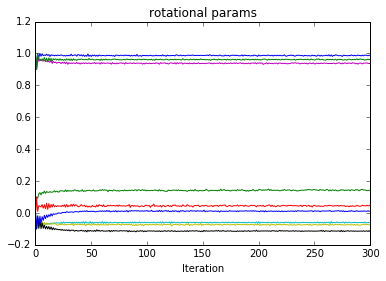

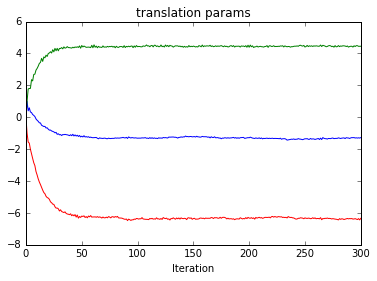

Best trial: 0
-5.96790935413 -5.9682222747
[[  9.85651530e-01   1.39380951e-01   4.11163043e-02  -1.08583564e+00]
 [ -5.72385290e-02   9.36547926e-01  -6.64044613e-02   4.29025835e+00]
 [ -1.08942612e-01   5.53274314e-03   9.55676328e-01  -5.94607738e+00]]


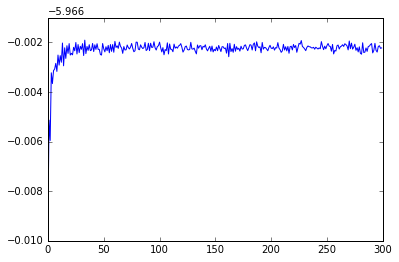

In [13]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [14]:
transform_parameters = {
    'parameters': T_all_trials[best_trial],
    'centroid_m': aligner.centroid_m,
    'centroid_f': aligner.centroid_f,
    'domain_m_origin_wrt_wholebrain': global_aligner_parameters['volume_moving_origin_wrt_wholebrain'],
    'domain_f_origin_wrt_wholebrain': global_aligner_parameters['volume_fixed_origin_wrt_wholebrain']
}

In [15]:
DataManager.save_alignment_results_v2(transform_parameters=transform_parameters,
                       score_traj=scores_all_trials[best_trial],
                       parameter_traj=traj_all_trials[best_trial],
                      alignment_spec=global_alignment_spec)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_parameters.json" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_parameters.json"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_scoreHistory.bp"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_do

In [16]:
volume_moving_tuples = \
        DataManager.load_original_volume_all_known_structures_v2(stack='atlasV5', sided=True, 
                                                              volume_type='score', 
                                                              include_surround=True,
                                                                return_label_mappings=False, 
                                                                 name_or_index_as_key='name',
                                                                 common_shape=False,
                                                                in_bbox_wrt='atlasSpace',
                                                                out_bbox_wrt='atlasSpace')

Prior structure/index map not found. Generating a new one.


In [17]:
transform_parameters = DataManager.load_alignment_parameters_v3(alignment_spec=global_alignment_spec)

In [38]:
for name_s, (vol, bbox_wrt_wholebrain) in volume_moving_tuples.iteritems():
    if convert_to_original_name(name_s) != '7N':
        continue
    transformed_vol, transformed_vol_box_wrt_fixedWholebrain = transform_volume_by_alignment_parameters(vol, bbox_wrt_wholebrain, transform_parameters=transform_parameters)
    print transformed_vol.shape, transformed_vol_box_wrt_fixedWholebrain
    DataManager.save_transformed_volume(volume=transformed_vol, 
                                        bbox=transformed_vol_box_wrt_fixedWholebrain, 
                                        alignment_spec=global_alignment_spec, 
                                        resolution=None, 
                                        structure=name_s)

Interpolating/filling sparse volume: 0.03 seconds.


(51, 73, 67) [784 856 395 445 333 399]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_R.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_R_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_

Interpolating/filling sparse volume: 0.03 seconds.


(47, 72, 69) [778 849 407 453 180 248]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_L_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_

Interpolating/filling sparse volume: 0.06 seconds.


(66, 90, 81) [775 864 388 453 325 405]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_R_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_R_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_R_surround_200_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep

Interpolating/filling sparse volume: 0.05 seconds.


(62, 88, 82) [770 857 400 461 175 256]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32_7N_L_surround_200_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_warp20_MD585_prep2_detector15_down32_scoreVolume_down32/score_volumes/atlasV5_down32_scoreVolume_warp20_MD585_prep

# Local

In [152]:
structure_m = '7N_L'

In [153]:
stack_m_spec = dict(name='atlasV5',
                   vol_type='score',
                   detector_id=None,
                   prep_id=None,
                   structure=structure_m,
                   resolution='down32')

stack_f_spec = dict(name='MD585',
                   vol_type='score',
                   detector_id=15,
                   prep_id=2,
                   structure=convert_to_original_name(structure_m),
                   resolution='down32')

In [154]:
init_alignment_stack_m_spec = dict(name='atlasV5',
                   vol_type='score',
                   detector_id=None,
                   prep_id=None,
                   structure=None,
                   resolution='down32')

init_alignment_stack_f_spec = dict(name='MD585',
                   vol_type='score',
                   detector_id=15,
                   prep_id=2,
                   structure=None,
                   resolution='down32')

initial_alignment_spec = dict(stack_m=init_alignment_stack_m_spec, 
                      stack_f=init_alignment_stack_f_spec,
                      warp_setting=20)

In [155]:
local_alignment_spec = dict(stack_m=stack_m_spec, 
                      stack_f=stack_f_spec,
                      warp_setting=17,
                           initial_alignment_spec=initial_alignment_spec)

In [156]:
local_aligner_parameters = generate_aligner_parameters(alignment_spec=local_alignment_spec,
structures_m=[structure_m]
)

upstream_warp_id                                                  20
transform_type                                                 rigid
terminate_thresh                                                 NaN
grad_computation_sample_number                                 10000
grid_search_sample_number                                        NaN
std_tx_um                                                        NaN
std_ty_um                                                        NaN
std_tz_um                                                        NaN
std_theta_xy_degree                                              NaN
surround_weight                                              inverse
regularization_weight                                              0
comment                           local reg with surr no grid search
max_iter_num                                                    1000
Name: 17, dtype: object
surround inverse True
{'warp_setting': 20, 'stack_f': {'prep_id': 2, 'name': 'M

Prior structure/index map not found. Generating a new one.
Loaded moving volumes: ['7N_L', '7N_L_surround_200'].
Prior structure/index map not found. Generating a new one.
File does not exist: /home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp
Error loading score volume for 7N_surround_200: [Errno 2] No such file or directory: '/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp'.
Loaded fixed volumes: ['7N'].
Computing structure sizes: 0.01 s


In [157]:
volume_fixed = local_aligner_parameters['volume_fixed']
volume_moving = local_aligner_parameters['volume_moving']

In [158]:
initial_shift_wrt_movingvol = get_centroid_3d(volume_moving[local_aligner_parameters['structure_to_label_moving'][structure_m]])
initial_shift_wrt_fixedvol = initial_shift_wrt_movingvol + local_aligner_parameters['volume_moving_origin_wrt_wholebrain'] - local_aligner_parameters['volume_fixed_origin_wrt_wholebrain']
print initial_shift_wrt_movingvol, initial_shift_wrt_fixedvol

[ 42.01808584  29.10509726  40.11418291] [ 261.01808584  313.10509726  104.11418291]


In [159]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=local_aligner_parameters['label_mapping_m2f'])

aligner.set_centroid(centroid_m=initial_shift_wrt_movingvol, 
                     centroid_f=initial_shift_wrt_fixedvol)

aligner.set_label_weights(label_weights=local_aligner_parameters['label_weights_m'])

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 42.01808584  29.10509726  40.11418291], centroid_f: [ 261.01808584  313.10509726  104.11418291]


In [160]:
gradients_f = compute_gradient(volume_fixed, smooth_first=True)
aligner.load_gradient(gradients=gradients_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1])


In [319]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=local_aligner_parameters['transform_type'], 
                                     max_iter_num=1000,
                                     history_len=20, 
                                     terminate_thresh_rot=.001,
                                     terminate_thresh_trans=.01,
                                     grad_computation_sample_number=local_aligner_parameters['grad_computation_sample_number'],
                                     lr1=1, lr2=.01
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Norm of gradient = 2.449490
around x=-5.45; around y=6.00; around z=5.45
step: 0.03 seconds
current score: -0.208778
new_T: [-1.09642191  0.89692141 -0.99334332]
det: 1.00

iteration 1
Norm of gradient = 1.527429
around x=-8.48; around y=0.61; around z=8.75
step: 0.03 seconds
current score: -0.208761
new_T: [-1.74285054  1.4841729  -0.78871391]
det: 1.00

iteration 2
Norm of gradient = 1.448043
around x=-10.04; around y=-4.23; around z=11.63
step: 0.03 seconds
current score: -0.208779
new_T: [-2.30738519  1.95949292 -0.06900922]
det: 1.00

iteration 3
Norm of gradient = 1.027670
around x=-12.24; around y=-6.64; around z=14.41
step: 0.03 seconds
current score: -0.208748
new_T: [-2.71182508  2.42892446  0.31547679]
det: 1.00

iteration 4
Norm of gradient = 1.093680
around x=-13.86; around y=-9.78; around z=16.96
step: 0.03 seconds
current score: -0.208735
new_T: [-3.13561187  2.83113099  0.87368704]
det: 1.00

iteration 5
Norm of gradient = 0.851598
around x=-15.03; around y

Norm of gradient = 0.076513
around x=-33.47; around y=-19.07; around z=45.21
Constrain around-z angle.
step: 0.03 seconds
current score: -0.208667
new_T: [-6.15134159  7.33469692  4.45963402]
det: 1.00

iteration 48
Norm of gradient = 0.135337
around x=-33.67; around y=-19.24; around z=45.37
Constrain around-z angle.
step: 0.03 seconds
current score: -0.208679
new_T: [-6.13709923  7.41167778  4.54547513]
det: 1.00

iteration 49
Norm of gradient = 0.088478
around x=-33.78; around y=-18.95; around z=45.21
Constrain around-z angle.
step: 0.03 seconds
current score: -0.208694
new_T: [-6.10608904  7.46554362  4.54134172]
det: 1.00

iteration 50
Norm of gradient = 0.340424
around x=-33.88; around y=-17.41; around z=45.19
Constrain around-z angle.
step: 0.03 seconds
current score: -0.208679
new_T: [-6.07673776  7.51167869  4.34224511]
det: 1.00

iteration 51
Norm of gradient = 0.166828
around x=-33.96; around y=-16.65; around z=45.18
Constrain around-z angle.
step: 0.03 seconds
current score:

Norm of gradient = 0.174795
around x=-31.21; around y=-17.28; around z=44.83
step: 0.03 seconds
current score: -0.208685
new_T: [-5.8219934   8.22675193  4.74106026]
det: 1.00

iteration 96
Norm of gradient = 0.071320
around x=-31.00; around y=-17.57; around z=44.69
step: 0.03 seconds
current score: -0.208708
new_T: [-5.82839412  8.20803009  4.76707246]
det: 1.00

iteration 97
Norm of gradient = 0.157357
around x=-30.78; around y=-16.92; around z=44.52
step: 0.03 seconds
current score: -0.208664
new_T: [-5.77122301  8.20596969  4.68443589]
det: 1.00

iteration 98
Norm of gradient = 0.098911
around x=-30.42; around y=-17.13; around z=44.17
step: 0.03 seconds
current score: -0.208672
new_T: [-5.73421035  8.16657734  4.69816165]
det: 1.00

iteration 99
Norm of gradient = 0.035740
around x=-30.24; around y=-17.17; around z=44.07
step: 0.03 seconds
current score: -0.208692
new_T: [-5.71964736  8.16402407  4.70502898]
det: 1.00

iteration 100
Norm of gradient = 0.080389
around x=-29.96; arou

Norm of gradient = 0.103781
around x=-25.38; around y=-17.49; around z=42.69
step: 0.03 seconds
current score: -0.208686
new_T: [-5.277806    8.43360635  4.93969859]
det: 1.00

iteration 144
Norm of gradient = 0.041255
around x=-25.25; around y=-17.40; around z=42.58
step: 0.03 seconds
current score: -0.208684
new_T: [-5.24890133  8.43224405  4.9343838 ]
det: 1.00

iteration 145
Norm of gradient = 0.093799
around x=-24.95; around y=-17.69; around z=42.34
step: 0.03 seconds
current score: -0.208663
new_T: [-5.21485781  8.41536462  4.97617603]
det: 1.00

iteration 146
Norm of gradient = 0.133862
around x=-25.08; around y=-17.53; around z=42.61
step: 0.03 seconds
current score: -0.208657
new_T: [-5.32740383  8.42544095  4.92863019]
det: 1.00

iteration 147
Norm of gradient = 0.044016
around x=-25.05; around y=-17.61; around z=42.67
step: 0.03 seconds
current score: -0.208632
new_T: [-5.3670447   8.42683043  4.93061073]
det: 1.00

iteration 148
Norm of gradient = 0.120974
around x=-25.00; 

Norm of gradient = 0.043460
around x=-20.68; around y=-16.91; around z=41.00
step: 0.03 seconds
current score: -0.208628
new_T: [-5.08927355  8.56334087  4.91690074]
det: 1.00

iteration 192
Norm of gradient = 0.096672
around x=-20.43; around y=-16.67; around z=40.73
step: 0.03 seconds
current score: -0.208678
new_T: [-5.08287999  8.52264645  4.8641865 ]
det: 1.00

iteration 193
Norm of gradient = 0.081725
around x=-20.36; around y=-16.96; around z=40.75
step: 0.03 seconds
current score: -0.208631
new_T: [-5.06832192  8.54235981  4.92098576]
det: 1.00

iteration 194
Norm of gradient = 0.059938
around x=-20.17; around y=-17.10; around z=40.61
step: 0.03 seconds
current score: -0.208683
new_T: [-5.03269285  8.53867474  4.94316928]
det: 1.00

iteration 195
Norm of gradient = 0.151084
around x=-19.89; around y=-16.58; around z=40.29
step: 0.03 seconds
current score: -0.208662
new_T: [-4.95698478  8.51983868  4.87609075]
det: 1.00

iteration 196
Norm of gradient = 0.044985
around x=-19.89; 

Norm of gradient = 0.167075
around x=-16.59; around y=-13.06; around z=38.89
step: 0.03 seconds
current score: -0.208642
new_T: [-4.63006564  8.66586985  4.43839136]
det: 1.00

iteration 240
Norm of gradient = 0.130010
around x=-16.67; around y=-12.48; around z=38.98
step: 0.03 seconds
current score: -0.208611
new_T: [-4.59886715  8.69918685  4.3751989 ]
det: 1.00

iteration 241
Norm of gradient = 0.056827
around x=-16.51; around y=-12.35; around z=38.81
step: 0.03 seconds
current score: -0.208674
new_T: [-4.59573379  8.6741231   4.3462341 ]
det: 1.00

iteration 242
Norm of gradient = 0.052971
around x=-16.56; around y=-12.16; around z=38.93
step: 0.03 seconds
current score: -0.208625
new_T: [-4.5959698   8.70246801  4.32630506]
det: 1.00

iteration 243
Norm of gradient = 0.040015
around x=-16.49; around y=-12.32; around z=38.90
step: 0.03 seconds
current score: -0.208636
new_T: [-4.589077    8.70544772  4.34958717]
det: 1.00

iteration 244
Norm of gradient = 0.142004
around x=-16.50; 

Norm of gradient = 0.077961
around x=-13.49; around y=-12.67; around z=37.42
step: 0.03 seconds
current score: -0.208640
new_T: [-4.79388889  8.60983107  4.22939697]
det: 1.00

iteration 288
Norm of gradient = 0.034107
around x=-13.43; around y=-12.67; around z=37.38
step: 0.03 seconds
current score: -0.208661
new_T: [-4.76632402  8.62133984  4.24069889]
det: 1.00

iteration 289
Norm of gradient = 0.124202
around x=-13.43; around y=-12.12; around z=37.32
step: 0.03 seconds
current score: -0.208646
new_T: [-4.74031343  8.62432557  4.16689697]
det: 1.00

iteration 290
Norm of gradient = 0.164241
around x=-13.14; around y=-12.79; around z=37.04
step: 0.03 seconds
current score: -0.208604
new_T: [-4.71253686  8.59029736  4.25387044]
det: 1.00

iteration 291
Norm of gradient = 0.057204
around x=-13.15; around y=-12.53; around z=37.06
step: 0.03 seconds
current score: -0.208648
new_T: [-4.6971677   8.60454296  4.22456099]
det: 1.00

iteration 292
Norm of gradient = 0.110824
around x=-13.25; 

Norm of gradient = 0.064267
around x=-10.55; around y=-11.31; around z=35.00
step: 0.03 seconds
current score: -0.208630
new_T: [-4.39782033  8.58463964  4.0655761 ]
det: 1.00

iteration 336
Norm of gradient = 0.155699
around x=-10.61; around y=-10.62; around z=35.01
step: 0.03 seconds
current score: -0.208615
new_T: [-4.39521797  8.59046716  3.96766668]
det: 1.00

iteration 337
Norm of gradient = 0.161627
around x=-10.49; around y=-11.26; around z=34.97
step: 0.03 seconds
current score: -0.208608
new_T: [-4.4886556   8.54969314  4.01938478]
det: 1.00

iteration 338
Norm of gradient = 0.057647
around x=-10.51; around y=-11.31; around z=35.05
step: 0.03 seconds
current score: -0.208628
new_T: [-4.454981    8.58721352  4.0422269 ]
det: 1.00

iteration 339
Norm of gradient = 0.042521
around x=-10.45; around y=-11.12; around z=35.02
step: 0.03 seconds
current score: -0.208612
new_T: [-4.44281178  8.59205928  4.02082224]
det: 1.00

iteration 340
Norm of gradient = 0.151972
around x=-10.55; 

Norm of gradient = 0.048262
around x=-9.74; around y=-8.04; around z=34.70
step: 0.03 seconds
current score: -0.208623
new_T: [-4.58574655  8.70966487  3.55686115]
det: 1.00

iteration 384
Norm of gradient = 0.081498
around x=-9.56; around y=-7.95; around z=34.41
step: 0.03 seconds
current score: -0.208654
new_T: [-4.5507425   8.66910703  3.53757442]
det: 1.00

iteration 385
Norm of gradient = 0.069245
around x=-9.51; around y=-8.24; around z=34.43
step: 0.03 seconds
current score: -0.208616
new_T: [-4.57004041  8.67332217  3.57796353]
det: 1.00

iteration 386
Norm of gradient = 0.047399
around x=-9.42; around y=-8.28; around z=34.34
step: 0.03 seconds
current score: -0.208660
new_T: [-4.60058254  8.64604119  3.56665119]
det: 1.00

iteration 387
Norm of gradient = 0.062477
around x=-9.45; around y=-8.35; around z=34.44
step: 0.03 seconds
current score: -0.208623
new_T: [-4.65901299  8.6457674   3.55951594]
det: 1.00

iteration 388
Norm of gradient = 0.040442
around x=-9.36; around y=-8

Norm of gradient = 0.033487
around x=-7.61; around y=-9.30; around z=33.05
step: 0.03 seconds
current score: -0.208606
new_T: [-4.4943089   8.69850673  3.72229888]
det: 1.00

iteration 432
Norm of gradient = 0.113049
around x=-7.73; around y=-8.80; around z=33.12
step: 0.03 seconds
current score: -0.208645
new_T: [-4.46950078  8.72967952  3.66667956]
det: 1.00

iteration 433
Norm of gradient = 0.022084
around x=-7.72; around y=-8.75; around z=33.12
step: 0.03 seconds
current score: -0.208629
new_T: [-4.4873553   8.72784566  3.65648763]
det: 1.00

iteration 434
Norm of gradient = 0.148379
around x=-7.47; around y=-9.38; around z=32.90
step: 0.03 seconds
current score: -0.208621
new_T: [-4.49826434  8.68679606  3.73122334]
det: 1.00

iteration 435
Norm of gradient = 0.120300
around x=-7.26; around y=-9.79; around z=32.68
step: 0.03 seconds
current score: -0.208582
new_T: [-4.44945986  8.67176854  3.79572836]
det: 1.00

iteration 436
Norm of gradient = 0.074802
around x=-7.10; around y=-9

Norm of gradient = 0.055880
around x=-6.23; around y=-7.60; around z=31.25
step: 0.03 seconds
current score: -0.208590
new_T: [-4.39763004  8.63102005  3.47380927]
det: 1.00

iteration 480
Norm of gradient = 0.079534
around x=-6.08; around y=-7.71; around z=31.05
step: 0.03 seconds
current score: -0.208624
new_T: [-4.33829056  8.62206491  3.49945595]
det: 1.00

iteration 481
Norm of gradient = 0.028421
around x=-6.08; around y=-7.60; around z=31.00
step: 0.03 seconds
current score: -0.208642
new_T: [-4.32072547  8.62771574  3.4919519 ]
det: 1.00

iteration 482
Norm of gradient = 0.122290
around x=-6.23; around y=-7.07; around z=31.09
step: 0.03 seconds
current score: -0.208610
new_T: [-4.28619017  8.66580338  3.43731521]
det: 1.00

iteration 483
Norm of gradient = 0.123867
around x=-6.43; around y=-6.70; around z=31.31
step: 0.03 seconds
current score: -0.208637
new_T: [-4.35099865  8.68621904  3.3737158 ]
det: 1.00

iteration 484
Norm of gradient = 0.050172
around x=-6.38; around y=-6

Norm of gradient = 0.084764
around x=-5.20; around y=-5.74; around z=29.73
step: 0.03 seconds
current score: -0.208644
new_T: [-4.36772026  8.58038687  3.20072178]
det: 1.00

iteration 528
Norm of gradient = 0.092801
around x=-5.39; around y=-5.41; around z=29.92
step: 0.03 seconds
current score: -0.208609
new_T: [-4.37996803  8.62140802  3.16169506]
det: 1.00

iteration 529
Norm of gradient = 0.061120
around x=-5.44; around y=-5.25; around z=30.00
step: 0.03 seconds
current score: -0.208625
new_T: [-4.42055676  8.62251116  3.129472  ]
det: 1.00

iteration 530
Norm of gradient = 0.057590
around x=-5.35; around y=-5.50; around z=29.92
step: 0.03 seconds
current score: -0.208594
new_T: [-4.42369583  8.61055965  3.16003163]
det: 1.00

iteration 531
Norm of gradient = 0.145109
around x=-5.55; around y=-4.94; around z=30.10
step: 0.03 seconds
current score: -0.208640
new_T: [-4.46952484  8.62908684  3.0743208 ]
det: 1.00

iteration 532
Norm of gradient = 0.108022
around x=-5.49; around y=-4

Norm of gradient = 0.049197
around x=-4.12; around y=-5.07; around z=28.25
step: 0.03 seconds
current score: -0.208584
new_T: [-4.23959833  8.58512413  3.13137153]
det: 1.00

iteration 576
Norm of gradient = 0.028260
around x=-4.12; around y=-5.06; around z=28.29
step: 0.03 seconds
current score: -0.208614
new_T: [-4.2663311   8.58386124  3.1251274 ]
det: 1.00

iteration 577
Norm of gradient = 0.052968
around x=-4.21; around y=-4.87; around z=28.39
step: 0.03 seconds
current score: -0.208610
new_T: [-4.27262518  8.60839312  3.1026738 ]
det: 1.00

iteration 578
Norm of gradient = 0.050979
around x=-4.17; around y=-4.95; around z=28.34
step: 0.03 seconds
current score: -0.208578
new_T: [-4.23515316  8.62146687  3.1285139 ]
det: 1.00

iteration 579
Norm of gradient = 0.088530
around x=-4.07; around y=-5.34; around z=28.31
step: 0.03 seconds
current score: -0.208628
new_T: [-4.26278377  8.609562    3.17314104]
det: 1.00

iteration 580
Norm of gradient = 0.026093
around x=-4.07; around y=-5

Norm of gradient = 0.042095
around x=-3.98; around y=-4.61; around z=28.22
step: 0.03 seconds
current score: -0.208641
new_T: [-4.54519231  8.67943676  3.02735767]
det: 1.00

iteration 624
Norm of gradient = 0.053515
around x=-4.00; around y=-4.42; around z=28.16
step: 0.03 seconds
current score: -0.208591
new_T: [-4.50992344  8.6895538   3.00955419]
det: 1.00

iteration 625
Norm of gradient = 0.074420
around x=-4.02; around y=-4.13; around z=28.04
step: 0.03 seconds
current score: -0.208637
new_T: [-4.47204093  8.68777378  2.97638346]
det: 1.00

iteration 626
Norm of gradient = 0.068920
around x=-4.08; around y=-3.82; around z=28.02
step: 0.03 seconds
current score: -0.208598
new_T: [-4.464769    8.68835111  2.93550362]
det: 1.00

iteration 627
Norm of gradient = 0.051505
around x=-4.14; around y=-3.73; around z=28.10
step: 0.03 seconds
current score: -0.208630
new_T: [-4.50619781  8.68999507  2.91600478]
det: 1.00

iteration 628
Norm of gradient = 0.064903
around x=-3.99; around y=-3

Norm of gradient = 0.102175
around x=-2.50; around y=-4.83; around z=25.95
step: 0.03 seconds
current score: -0.208573
new_T: [-4.33522465  8.5266842   3.08936819]
det: 1.00

iteration 672
Norm of gradient = 0.090391
around x=-2.45; around y=-4.52; around z=25.72
step: 0.03 seconds
current score: -0.208571
new_T: [-4.30286623  8.49577247  3.04810524]
det: 1.00

iteration 673
Norm of gradient = 0.018506
around x=-2.45; around y=-4.57; around z=25.74
step: 0.03 seconds
current score: -0.208650
new_T: [-4.31877081  8.49431642  3.05180541]
det: 1.00

iteration 674
Norm of gradient = 0.040015
around x=-2.41; around y=-4.54; around z=25.65
step: 0.03 seconds
current score: -0.208633
new_T: [-4.34074996  8.46747036  3.03999927]
det: 1.00

iteration 675
Norm of gradient = 0.065325
around x=-2.36; around y=-4.78; around z=25.69
step: 0.03 seconds
current score: -0.208565
new_T: [-4.3823576   8.46115649  3.06360797]
det: 1.00

iteration 676
Norm of gradient = 0.071122
around x=-2.37; around y=-4

Norm of gradient = 0.072185
around x=-2.76; around y=-2.59; around z=25.30
step: 0.03 seconds
current score: -0.208624
new_T: [-4.33261608  8.61382091  2.80077891]
det: 1.00

iteration 720
Norm of gradient = 0.105707
around x=-2.54; around y=-2.99; around z=25.13
step: 0.03 seconds
current score: -0.208554
new_T: [-4.31684761  8.58959371  2.85695161]
det: 1.00

iteration 721
Norm of gradient = 0.025067
around x=-2.48; around y=-3.06; around z=25.05
step: 0.03 seconds
current score: -0.208629
new_T: [-4.31275948  8.5789298   2.86613778]
det: 1.00

iteration 722
Norm of gradient = 0.058832
around x=-2.50; around y=-2.84; around z=24.95
step: 0.03 seconds
current score: -0.208611
new_T: [-4.28044427  8.57679394  2.84275226]
det: 1.00

iteration 723
Norm of gradient = 0.068297
around x=-2.43; around y=-3.11; around z=24.97
step: 0.03 seconds
current score: -0.208590
new_T: [-4.27294138  8.59294482  2.88676815]
det: 1.00

iteration 724
Norm of gradient = 0.064315
around x=-2.39; around y=-3

Norm of gradient = 0.068194
around x=-2.09; around y=-2.36; around z=23.94
step: 0.03 seconds
current score: -0.208575
new_T: [-4.2383948   8.58259476  2.79842519]
det: 1.00

iteration 768
Norm of gradient = 0.071663
around x=-2.24; around y=-2.13; around z=24.08
step: 0.03 seconds
current score: -0.208581
new_T: [-4.26241977  8.60394943  2.76281576]
det: 1.00

iteration 769
Norm of gradient = 0.086696
around x=-2.41; around y=-1.81; around z=24.19
step: 0.03 seconds
current score: -0.208610
new_T: [-4.28882066  8.61953503  2.71523108]
det: 1.00

iteration 770
Norm of gradient = 0.067768
around x=-2.55; around y=-1.65; around z=24.36
step: 0.03 seconds
current score: -0.208608
new_T: [-4.32077087  8.64589501  2.68955709]
det: 1.00

iteration 771
Norm of gradient = 0.051768
around x=-2.66; around y=-1.63; around z=24.52
step: 0.03 seconds
current score: -0.208565
new_T: [-4.3500368   8.6721689   2.68441459]
det: 1.00

iteration 772
Norm of gradient = 0.147033
around x=-2.38; around y=-2

Norm of gradient = 0.050447
around x=-1.59; around y=-2.41; around z=23.13
step: 0.03 seconds
current score: -0.208567
new_T: [-4.43941937  8.51907652  2.77029411]
det: 1.00

iteration 816
Norm of gradient = 0.028864
around x=-1.60; around y=-2.45; around z=23.16
step: 0.03 seconds
current score: -0.208610
new_T: [-4.4665125   8.51478465  2.76810739]
det: 1.00

iteration 817
Norm of gradient = 0.029404
around x=-1.54; around y=-2.49; around z=23.07
step: 0.03 seconds
current score: -0.208629
new_T: [-4.47565638  8.49511033  2.76959895]
det: 1.00

iteration 818
Norm of gradient = 0.009716
around x=-1.53; around y=-2.52; around z=23.08
step: 0.03 seconds
current score: -0.208556
new_T: [-4.48215247  8.49712304  2.77383801]
det: 1.00

iteration 819
Norm of gradient = 0.075638
around x=-1.46; around y=-2.83; around z=23.16
step: 0.03 seconds
current score: -0.208525
new_T: [-4.49740663  8.51346305  2.81845244]
det: 1.00

iteration 820
Norm of gradient = 0.050489
around x=-1.57; around y=-2

Norm of gradient = 0.077245
around x=-0.94; around y=-2.10; around z=21.77
step: 0.03 seconds
current score: -0.208589
new_T: [-4.35069976  8.46487049  2.77751924]
det: 1.00

iteration 864
Norm of gradient = 0.079396
around x=-1.05; around y=-1.76; around z=21.74
step: 0.03 seconds
current score: -0.208535
new_T: [-4.34119685  8.46602388  2.73085522]
det: 1.00

iteration 865
Norm of gradient = 0.024836
around x=-1.02; around y=-1.74; around z=21.66
step: 0.03 seconds
current score: -0.208612
new_T: [-4.32250494  8.46152867  2.73240622]
det: 1.00

iteration 866
Norm of gradient = 0.040654
around x=-1.06; around y=-1.70; around z=21.66
step: 0.03 seconds
current score: -0.208574
new_T: [-4.2912961   8.48485811  2.73864054]
det: 1.00

iteration 867
Norm of gradient = 0.062909
around x=-0.91; around y=-1.91; around z=21.57
step: 0.03 seconds
current score: -0.208632
new_T: [-4.31024399  8.45579298  2.76063241]
det: 1.00

iteration 868
Norm of gradient = 0.073968
around x=-1.02; around y=-1

Norm of gradient = 0.024802
around x=-0.25; around y=-2.47; around z=20.81
step: 0.03 seconds
current score: -0.208607
new_T: [-4.43813493  8.39420544  2.83808491]
det: 1.00

iteration 912
Norm of gradient = 0.064547
around x=-0.11; around y=-2.57; around z=20.63
step: 0.03 seconds
current score: -0.208583
new_T: [-4.40090424  8.37759324  2.86206126]
det: 1.00

iteration 913
Norm of gradient = 0.037914
around x=-0.04; around y=-2.68; around z=20.57
step: 0.03 seconds
current score: -0.208606
new_T: [-4.3808204   8.38005905  2.88315851]
det: 1.00

iteration 914
Norm of gradient = 0.111305
around x=-0.25; around y=-2.22; around z=20.63
step: 0.03 seconds
current score: -0.208597
new_T: [-4.38640782  8.39205333  2.81788916]
det: 1.00

iteration 915
Norm of gradient = 0.088232
around x=-0.40; around y=-2.03; around z=20.74
step: 0.03 seconds
current score: -0.208644
new_T: [-4.44817565  8.38623731  2.77426139]
det: 1.00

iteration 916
Norm of gradient = 0.075938
around x=-0.51; around y=-1

Norm of gradient = 0.069212
around x=-0.43; around y=-1.18; around z=20.06
step: 0.03 seconds
current score: -0.208589
new_T: [-4.34593284  8.46546591  2.70343439]
det: 1.00

iteration 960
Norm of gradient = 0.050049
around x=-0.33; around y=-1.38; around z=20.00
step: 0.03 seconds
current score: -0.208624
new_T: [-4.3401164   8.45935715  2.7330355 ]
det: 1.00

iteration 961
Norm of gradient = 0.082958
around x=-0.51; around y=-1.18; around z=20.21
step: 0.03 seconds
current score: -0.208596
new_T: [-4.38156313  8.48644964  2.70112367]
det: 1.00

iteration 962
Norm of gradient = 0.063703
around x=-0.37; around y=-1.31; around z=20.04
step: 0.03 seconds
current score: -0.208625
new_T: [-4.34863779  8.46837555  2.72701221]
det: 1.00

iteration 963
Norm of gradient = 0.064110
around x=-0.36; around y=-1.52; around z=20.18
step: 0.03 seconds
current score: -0.208627
new_T: [-4.37163655  8.49269513  2.75758121]
det: 1.00

iteration 964
Norm of gradient = 0.112907
around x=-0.58; around y=-1

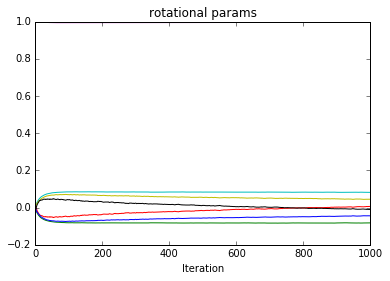

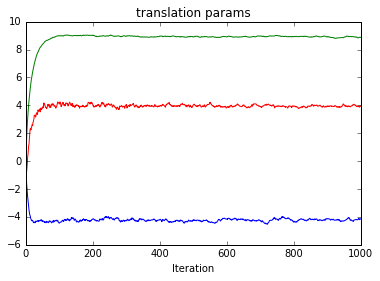

Best trial: 0
-0.138579264627 -0.138703625399
[[  9.96616136e-01  -8.21118690e-02   3.73063627e-03  -4.22305890e+00]
 [  8.18543474e-02   9.95581312e-01   4.60186500e-02   8.83973408e+00]
 [ -7.49282911e-03  -4.55575603e-02   9.98933615e-01   3.88671904e+00]]


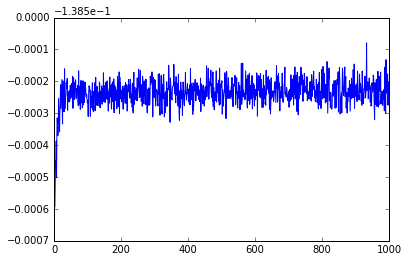

In [162]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [163]:
local_transform_parameters = {
    'parameters': T_all_trials[best_trial],
    'centroid_m': aligner.centroid_m,
    'centroid_f': aligner.centroid_f,
    'domain_m_origin_wrt_wholebrain': local_aligner_parameters['volume_moving_origin_wrt_wholebrain'],
    'domain_f_origin_wrt_wholebrain': local_aligner_parameters['volume_fixed_origin_wrt_wholebrain']
}

In [164]:
DataManager.save_alignment_results_v2(transform_parameters=local_transform_parameters,
                       score_traj=scores_all_trials[best_trial],
                       parameter_traj=traj_all_trials[best_trial],
                      alignment_spec=local_alignment_spec)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_parameters.json" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_parameters.json"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_scoreHistory.bp"
aws s3 c

In [134]:
volume, bbox_wrt_wholebrain = \
DataManager.load_original_volume_all_known_structures_v2(stack='atlasV5', sided=True, 
                                                              volume_type='score', 
                                                              include_surround=True,
                                                                return_label_mappings=False, 
                                                                 name_or_index_as_key='name',
                                                                 common_shape=False,
                                                                in_bbox_wrt='atlasSpace',
                                                                out_bbox_wrt='atlasSpace',
                                                                structures=[structure_m])[structure_m]

global_transform_parameters = DataManager.load_alignment_parameters_v3(alignment_spec=global_alignment_spec)
local_transform_parameters = DataManager.load_alignment_parameters_v3(alignment_spec=local_alignment_spec)

T = compose_alignment_parameters([global_transform_parameters, local_transform_parameters])

transformed_vol, transformed_vol_box_wrt_fixedWholebrain = \
transform_volume_v3(vol=volume, bbox=bbox_wrt_wholebrain, tf_params=T[:3].flatten())

print structure_m, transformed_vol.shape, transformed_vol_box_wrt_fixedWholebrain

DataManager.save_transformed_volume(volume=transformed_vol, 
                                    bbox=transformed_vol_box_wrt_fixedWholebrain, 
                                    alignment_spec=local_alignment_spec, 
                                    resolution=None, 
                                    structure=structure_m)

Prior structure/index map not found. Generating a new one.
Interpolating/filling sparse volume: 0.03 seconds.


7N_L (45, 71, 67) [774 844 417 461 185 251]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp17_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVo

# Local 2

In [320]:
structure_m = '7N_L'

In [321]:
stack_m_spec = dict(name='atlasV5',
                   vol_type='score',
                   detector_id=None,
                   prep_id=None,
                   structure=structure_m,
                   resolution='down32')

stack_f_spec = dict(name='MD585',
                   vol_type='score',
                   detector_id=15,
                   prep_id=2,
                   structure=convert_to_original_name(structure_m),
                   resolution='down32')

In [322]:
local_alignment_spec = dict(stack_m=stack_m_spec, 
                      stack_f=stack_f_spec,
                      warp_setting=27)

In [323]:
local_aligner_parameters = generate_aligner_parameters(alignment_spec=local_alignment_spec,
structures_m=[structure_m]
)

upstream_warp_id                                                               None
transform_type                                                                rigid
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                       NaN
std_ty_um                                                                       NaN
std_tz_um                                                                       NaN
std_theta_xy_degree                                                             NaN
surround_weight                                                             inverse
regularization_weight                                                             0
comment                           local reg with surr with global transform 

Prior structure/index map not found. Generating a new one.
Loaded moving volumes: ['7N_L', '7N_L_surround_200'].
Prior structure/index map not found. Generating a new one.


rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp" "/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp"


File does not exist: /home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp
Error loading score volume for 7N_surround_200: [Errno 2] No such file or directory: '/home/yuncong/CSHL_volumes/MD585/MD585_prep2_detector15_down32_scoreVolume/score_volumes/MD585_prep2_detector15_down32_scoreVolume_7N_surround_200.bp'.
Loaded fixed volumes: ['7N'].
Computing structure sizes: 1.73 s


In [324]:
global_alignment_stack_m_spec = dict(name='atlasV5',
                   vol_type='score',
                   detector_id=None,
                   prep_id=None,
                   structure=None,
                   resolution='down32')
global_alignment_stack_f_spec = dict(name='MD585',
                   vol_type='score',
                   detector_id=15,
                   prep_id=2,
                   structure=None,
                   resolution='down32')
global_alignment_spec = dict(stack_m=global_alignment_stack_m_spec, 
                      stack_f=global_alignment_stack_f_spec,
                      warp_setting=20)

In [325]:
global_transform_parameters = DataManager.load_alignment_parameters_v3(global_alignment_spec)

In [326]:
volume_fixed = local_aligner_parameters['volume_fixed']
volume_moving = local_aligner_parameters['volume_moving']

In [327]:
init_shift_wrt_movingvol = get_centroid_3d(volume_moving[local_aligner_parameters['structure_to_label_moving'][structure_m]])
init_shift_wrt_fixedvol = transform_points_by_transform_parameters(pts=[init_shift_wrt_movingvol + global_transform_parameters['domain_m_origin_wrt_wholebrain']],
transform_parameters=global_transform_parameters)[0] - global_transform_parameters['domain_f_origin_wrt_wholebrain']

print init_shift_wrt_movingvol, init_shift_wrt_fixedvol

[ 225.97802909  321.25684995  127.02230353] [ 262.04415679  313.8423543   104.05144257]


In [328]:
def transform_parameters_to_init_T(global_transform_parameters, local_aligner_parameters, centroid_m, centroid_f):
    """
    `init_T` is on top of shifting moving volume by `centroid_m` and shifting fixed volume by `centroid_f`.
    
    Returns:
        (3,4)-array:
    """
    
    T = alignment_parameters_to_transform_matrix(global_transform_parameters)
    R = T[:3,:3]
    t = T[:3,3]
    
    lof = local_aligner_parameters['volume_fixed_origin_wrt_wholebrain']
    lom = local_aligner_parameters['volume_moving_origin_wrt_wholebrain']
                
    init_T = np.column_stack([R, np.dot(R, lom + centroid_m) + t - lof - centroid_f])
    return init_T

init_T = transform_parameters_to_init_T(global_transform_parameters, local_aligner_parameters,
                                       centroid_m=init_shift_wrt_movingvol, 
                                        centroid_f=init_shift_wrt_fixedvol)
print init_T

[[ 0.98565153  0.13938095  0.0411163   0.        ]
 [-0.05723853  0.93654793 -0.06640446  0.        ]
 [-0.10894261  0.00553274  0.95567633  0.        ]]


In [329]:
# initial_shift_wrt_fixedvol = initial_shift_wrt_movingvol + local_aligner_parameters['volume_moving_origin_wrt_wholebrain'] - local_aligner_parameters['volume_fixed_origin_wrt_wholebrain']
# print initial_shift_wrt_movingvol, initial_shift_wrt_fixedvol

In [330]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=local_aligner_parameters['label_mapping_m2f'])
aligner.set_centroid(centroid_m=init_shift_wrt_movingvol, 
                     centroid_f=init_shift_wrt_fixedvol)
# aligner.set_centroid(centroid_m=np.zeros((3,)), 
#                      centroid_f=np.zeros((3,)))
aligner.set_label_weights(label_weights=local_aligner_parameters['label_weights_m'])

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [ 225.97802909  321.25684995  127.02230353], centroid_f: [ 262.04415679  313.8423543   104.05144257]


In [331]:
gradients_f = compute_gradient(volume_fixed, smooth_first=True)
aligner.load_gradient(gradients=gradients_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1])


In [339]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=local_aligner_parameters['transform_type'], 
                                     max_iter_num=1000,
                                     history_len=20, 
                                     terminate_thresh_rot=.001,
                                     terminate_thresh_trans=.01,
                                     grad_computation_sample_number=local_aligner_parameters['grad_computation_sample_number'],
                                     lr1=1, lr2=.01,
                                     init_T=init_T.flatten()
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
Norm of gradient = 2.449490
around x=-0.15; around y=5.69; around z=-2.81
step: 0.03 seconds
current score: -0.208748
new_T: [-0.99993333  0.98996692 -1.0099664 ]
det: 0.90

iteration 1
Norm of gradient = 1.770106
around x=-0.37; around y=5.14; around z=-2.45
step: 0.03 seconds
current score: -0.208664
new_T: [-1.70227752  1.65156095 -0.25216959]
det: 0.90

iteration 2
Norm of gradient = 1.139270
around x=-0.63; around y=4.87; around z=-2.17
step: 0.03 seconds
current score: -0.208678
new_T: [-2.21380465  2.18560642 -0.21241201]
det: 0.90

iteration 3
Norm of gradient = 1.054310
around x=-0.84; around y=4.61; around z=-1.93
step: 0.03 seconds
current score: -0.208676
new_T: [-2.54814498  2.66286504  0.22976047]
det: 0.90

iteration 4
Norm of gradient = 0.763005
around x=-1.05; around y=4.48; around z=-1.74
step: 0.03 seconds
current score: -0.208639
new_T: [-2.83889891  3.04641081  0.10432089]
det: 0.90

iteration 5
Norm of gradient = 0.835169
around x=-1.26; around y=4.40

Norm of gradient = 0.108032
around x=-2.98; around y=2.94; around z=0.55
step: 0.03 seconds
current score: -0.208485
new_T: [-4.61067109  7.79957381  3.14700537]
det: 0.90

iteration 48
Norm of gradient = 0.096133
around x=-3.00; around y=2.94; around z=0.57
step: 0.03 seconds
current score: -0.208546
new_T: [-4.6907282   7.81674709  3.11686967]
det: 0.90

iteration 49
Norm of gradient = 0.155220
around x=-3.01; around y=2.90; around z=0.60
step: 0.03 seconds
current score: -0.208524
new_T: [-4.77581108  7.87404626  3.17129146]
det: 0.90

iteration 50
Norm of gradient = 0.223461
around x=-3.08; around y=2.98; around z=0.62
step: 0.03 seconds
current score: -0.208550
new_T: [-4.76248239  7.91777185  3.03741204]
det: 0.90

iteration 51
Norm of gradient = 0.065102
around x=-3.09; around y=2.98; around z=0.63
step: 0.03 seconds
current score: -0.208537
new_T: [-4.73809116  7.9562061   3.05887327]
det: 0.90

iteration 52
Norm of gradient = 0.049483
around x=-3.09; around y=2.97; around z=0.

Norm of gradient = 0.104108
around x=-3.15; around y=3.36; around z=0.77
step: 0.03 seconds
current score: -0.208570
new_T: [-4.66756313  8.23367197  3.11678739]
det: 0.90

iteration 96
Norm of gradient = 0.067396
around x=-3.13; around y=3.37; around z=0.76
step: 0.03 seconds
current score: -0.208489
new_T: [-4.62583873  8.22226555  3.14617002]
det: 0.90

iteration 97
Norm of gradient = 0.110496
around x=-3.08; around y=3.35; around z=0.75
step: 0.03 seconds
current score: -0.208521
new_T: [-4.63491242  8.18351575  3.19831442]
det: 0.90

iteration 98
Norm of gradient = 0.062602
around x=-3.10; around y=3.37; around z=0.75
step: 0.03 seconds
current score: -0.208528
new_T: [-4.62833937  8.19830375  3.16838022]
det: 0.90

iteration 99
Norm of gradient = 0.239738
around x=-3.15; around y=3.46; around z=0.75
step: 0.03 seconds
current score: -0.208529
new_T: [-4.65658469  8.19800214  3.00947739]
det: 0.90

iteration 100
Norm of gradient = 0.057236
around x=-3.13; around y=3.45; around z=0

Norm of gradient = 0.185607
around x=-2.95; around y=3.62; around z=0.77
step: 0.03 seconds
current score: -0.208548
new_T: [-4.79804776  8.1236557   3.2177581 ]
det: 0.90

iteration 144
Norm of gradient = 0.345182
around x=-3.04; around y=3.75; around z=0.77
step: 0.03 seconds
current score: -0.208552
new_T: [-4.75326921  8.14876736  3.01602805]
det: 0.90

iteration 145
Norm of gradient = 0.095074
around x=-3.06; around y=3.79; around z=0.76
step: 0.03 seconds
current score: -0.208539
new_T: [-4.78426737  8.13902977  2.95724062]
det: 0.90

iteration 146
Norm of gradient = 0.213484
around x=-3.01; around y=3.70; around z=0.78
step: 0.03 seconds
current score: -0.208580
new_T: [-4.83696047  8.15354631  3.08562414]
det: 0.90

iteration 147
Norm of gradient = 0.093437
around x=-3.00; around y=3.68; around z=0.79
step: 0.03 seconds
current score: -0.208484
new_T: [-4.80484957  8.18337452  3.15311817]
det: 0.90

iteration 148
Norm of gradient = 0.065831
around x=-3.01; around y=3.68; around

Norm of gradient = 0.049053
around x=-2.90; around y=3.85; around z=0.90
step: 0.03 seconds
current score: -0.208519
new_T: [-4.85935016  8.3444611   3.33059787]
det: 0.90

iteration 192
Norm of gradient = 0.175646
around x=-2.95; around y=3.91; around z=0.91
step: 0.03 seconds
current score: -0.208543
new_T: [-4.8588007   8.37503731  3.23081191]
det: 0.90

iteration 193
Norm of gradient = 0.109079
around x=-2.92; around y=3.88; around z=0.90
step: 0.03 seconds
current score: -0.208535
new_T: [-4.85268588  8.35879476  3.2973382 ]
det: 0.90

iteration 194
Norm of gradient = 0.100400
around x=-2.94; around y=3.92; around z=0.90
step: 0.03 seconds
current score: -0.208551
new_T: [-4.84143439  8.37032151  3.24324104]
det: 0.90

iteration 195
Norm of gradient = 0.192876
around x=-2.99; around y=3.99; around z=0.91
step: 0.03 seconds
current score: -0.208462
new_T: [-4.85899257  8.3723626   3.12054357]
det: 0.90

iteration 196
Norm of gradient = 0.076621
around x=-2.98; around y=4.01; around

Norm of gradient = 0.097881
around x=-2.72; around y=4.04; around z=0.90
step: 0.03 seconds
current score: -0.208529
new_T: [-4.80586156  8.2949133   3.45585467]
det: 0.90

iteration 240
Norm of gradient = 0.090730
around x=-2.71; around y=4.06; around z=0.88
step: 0.03 seconds
current score: -0.208526
new_T: [-4.73397562  8.27569037  3.46005628]
det: 0.90

iteration 241
Norm of gradient = 0.096430
around x=-2.72; around y=4.08; around z=0.88
step: 0.03 seconds
current score: -0.208516
new_T: [-4.65115918  8.29954183  3.45853037]
det: 0.90

iteration 242
Norm of gradient = 0.049187
around x=-2.73; around y=4.09; around z=0.88
step: 0.03 seconds
current score: -0.208532
new_T: [-4.61079316  8.31304166  3.46066169]
det: 0.90

iteration 243
Norm of gradient = 0.114040
around x=-2.76; around y=4.13; around z=0.88
step: 0.03 seconds
current score: -0.208564
new_T: [-4.63255962  8.3183803   3.38950316]
det: 0.90

iteration 244
Norm of gradient = 0.054272
around x=-2.76; around y=4.15; around

Norm of gradient = 0.075196
around x=-2.84; around y=4.54; around z=0.89
step: 0.03 seconds
current score: -0.208532
new_T: [-4.54061565  8.34886417  3.07696023]
det: 0.90

iteration 288
Norm of gradient = 0.030414
around x=-2.83; around y=4.54; around z=0.89
step: 0.03 seconds
current score: -0.208501
new_T: [-4.52154107  8.339635    3.08324889]
det: 0.90

iteration 289
Norm of gradient = 0.187102
around x=-2.77; around y=4.49; around z=0.88
step: 0.03 seconds
current score: -0.208521
new_T: [-4.4628891   8.33268928  3.2038088 ]
det: 0.90

iteration 290
Norm of gradient = 0.229082
around x=-2.83; around y=4.58; around z=0.87
step: 0.03 seconds
current score: -0.208545
new_T: [-4.42827759  8.34691552  3.06948439]
det: 0.90

iteration 291
Norm of gradient = 0.041667
around x=-2.82; around y=4.56; around z=0.88
step: 0.03 seconds
current score: -0.208588
new_T: [-4.43414126  8.34690608  3.0957306 ]
det: 0.90

iteration 292
Norm of gradient = 0.048460
around x=-2.80; around y=4.57; around

Norm of gradient = 0.054987
around x=-2.71; around y=4.67; around z=0.93
step: 0.03 seconds
current score: -0.208486
new_T: [-4.53736174  8.36790225  3.17665117]
det: 0.90

iteration 336
Norm of gradient = 0.153827
around x=-2.75; around y=4.72; around z=0.93
step: 0.03 seconds
current score: -0.208534
new_T: [-4.57951077  8.37270054  3.07840715]
det: 0.90

iteration 337
Norm of gradient = 0.055416
around x=-2.76; around y=4.74; around z=0.92
step: 0.03 seconds
current score: -0.208520
new_T: [-4.5479941   8.36425745  3.05793443]
det: 0.90

iteration 338
Norm of gradient = 0.109791
around x=-2.78; around y=4.78; around z=0.91
step: 0.03 seconds
current score: -0.208501
new_T: [-4.56682412  8.33403418  2.98690065]
det: 0.90

iteration 339
Norm of gradient = 0.049080
around x=-2.77; around y=4.77; around z=0.92
step: 0.03 seconds
current score: -0.208522
new_T: [-4.57253197  8.35614755  3.01649887]
det: 0.90

iteration 340
Norm of gradient = 0.046981
around x=-2.77; around y=4.78; around

Norm of gradient = 0.033505
around x=-2.65; around y=4.93; around z=0.93
step: 0.03 seconds
current score: -0.208484
new_T: [-4.58125314  8.2921566   3.03994223]
det: 0.90

iteration 384
Norm of gradient = 0.050613
around x=-2.65; around y=4.92; around z=0.94
step: 0.03 seconds
current score: -0.208550
new_T: [-4.61402531  8.31161878  3.05045756]
det: 0.90

iteration 385
Norm of gradient = 0.043793
around x=-2.65; around y=4.93; around z=0.94
step: 0.03 seconds
current score: -0.208465
new_T: [-4.64560568  8.30668185  3.02837602]
det: 0.90

iteration 386
Norm of gradient = 0.128936
around x=-2.61; around y=4.89; around z=0.94
step: 0.03 seconds
current score: -0.208508
new_T: [-4.62115901  8.30715749  3.11333377]
det: 0.90

iteration 387
Norm of gradient = 0.077749
around x=-2.61; around y=4.89; around z=0.95
step: 0.03 seconds
current score: -0.208480
new_T: [-4.69500728  8.29851913  3.09816286]
det: 0.90

iteration 388
Norm of gradient = 0.096092
around x=-2.59; around y=4.88; around

Norm of gradient = 0.090982
around x=-2.54; around y=4.95; around z=1.02
step: 0.03 seconds
current score: -0.208551
new_T: [-4.99178899  8.30295493  3.15677291]
det: 0.90

iteration 432
Norm of gradient = 0.041357
around x=-2.53; around y=4.94; around z=1.03
step: 0.03 seconds
current score: -0.208543
new_T: [-5.0033647   8.31690979  3.18015221]
det: 0.90

iteration 433
Norm of gradient = 0.022059
around x=-2.53; around y=4.94; around z=1.04
step: 0.03 seconds
current score: -0.208487
new_T: [-5.02031705  8.32097241  3.17311633]
det: 0.90

iteration 434
Norm of gradient = 0.115393
around x=-2.51; around y=4.90; around z=1.05
step: 0.03 seconds
current score: -0.208583
new_T: [-5.07411026  8.33715486  3.23036791]
det: 0.90

iteration 435
Norm of gradient = 0.052103
around x=-2.51; around y=4.92; around z=1.05
step: 0.03 seconds
current score: -0.208527
new_T: [-5.09329509  8.30899455  3.20405028]
det: 0.90

iteration 436
Norm of gradient = 0.040940
around x=-2.52; around y=4.92; around

Norm of gradient = 0.036731
around x=-2.47; around y=5.12; around z=0.99
step: 0.03 seconds
current score: -0.208524
new_T: [-4.90090757  8.24271315  3.1526002 ]
det: 0.90

iteration 480
Norm of gradient = 0.156734
around x=-2.52; around y=5.18; around z=0.99
step: 0.03 seconds
current score: -0.208483
new_T: [-4.88083489  8.2558395   3.06055503]
det: 0.90

iteration 481
Norm of gradient = 0.052318
around x=-2.53; around y=5.19; around z=1.00
step: 0.03 seconds
current score: -0.208523
new_T: [-4.86019812  8.28865162  3.05607138]
det: 0.90

iteration 482
Norm of gradient = 0.095243
around x=-2.51; around y=5.19; around z=0.99
step: 0.03 seconds
current score: -0.208538
new_T: [-4.78693698  8.27750519  3.09127798]
det: 0.90

iteration 483
Norm of gradient = 0.116170
around x=-2.50; around y=5.21; around z=0.96
step: 0.03 seconds
current score: -0.208497
new_T: [-4.69756224  8.24725394  3.09974117]
det: 0.90

iteration 484
Norm of gradient = 0.105867
around x=-2.47; around y=5.17; around

Norm of gradient = 0.020687
around x=-2.48; around y=5.33; around z=1.01
step: 0.03 seconds
current score: -0.208518
new_T: [-4.84235618  8.27628315  3.07365421]
det: 0.90

iteration 528
Norm of gradient = 0.037119
around x=-2.48; around y=5.33; around z=1.01
step: 0.03 seconds
current score: -0.208551
new_T: [-4.8184265   8.29800485  3.08770751]
det: 0.90

iteration 529
Norm of gradient = 0.095770
around x=-2.50; around y=5.37; around z=1.01
step: 0.03 seconds
current score: -0.208558
new_T: [-4.76587449  8.31911004  3.05358378]
det: 0.90

iteration 530
Norm of gradient = 0.069753
around x=-2.48; around y=5.37; around z=0.99
step: 0.03 seconds
current score: -0.208562
new_T: [-4.74401238  8.27995133  3.06560588]
det: 0.90

iteration 531
Norm of gradient = 0.047298
around x=-2.47; around y=5.37; around z=0.98
step: 0.03 seconds
current score: -0.208531
new_T: [-4.71502136  8.26469698  3.07963192]
det: 0.90

iteration 532
Norm of gradient = 0.054018
around x=-2.49; around y=5.39; around

Norm of gradient = 0.066139
around x=-2.50; around y=5.54; around z=1.04
step: 0.03 seconds
current score: -0.208584
new_T: [-4.74751183  8.36413393  3.0093556 ]
det: 0.90

iteration 576
Norm of gradient = 0.050596
around x=-2.49; around y=5.54; around z=1.03
step: 0.03 seconds
current score: -0.208558
new_T: [-4.78490175  8.33681905  3.00462088]
det: 0.90

iteration 577
Norm of gradient = 0.053814
around x=-2.49; around y=5.55; around z=1.03
step: 0.03 seconds
current score: -0.208504
new_T: [-4.81878353  8.31477535  2.97598517]
det: 0.90

iteration 578
Norm of gradient = 0.021575
around x=-2.50; around y=5.55; around z=1.03
step: 0.03 seconds
current score: -0.208495
new_T: [-4.80117642  8.32400875  2.98328974]
det: 0.90

iteration 579
Norm of gradient = 0.119757
around x=-2.46; around y=5.51; around z=1.03
step: 0.03 seconds
current score: -0.208544
new_T: [-4.78817765  8.31611317  3.05667559]
det: 0.90

iteration 580
Norm of gradient = 0.052323
around x=-2.45; around y=5.49; around

Norm of gradient = 0.076284
around x=-2.39; around y=5.59; around z=1.03
step: 0.03 seconds
current score: -0.208549
new_T: [-4.81844654  8.28949959  3.11507596]
det: 0.90

iteration 624
Norm of gradient = 0.017838
around x=-2.40; around y=5.59; around z=1.04
step: 0.03 seconds
current score: -0.208453
new_T: [-4.82453947  8.29534086  3.10926116]
det: 0.90

iteration 625
Norm of gradient = 0.054535
around x=-2.40; around y=5.59; around z=1.05
step: 0.03 seconds
current score: -0.208503
new_T: [-4.86155445  8.31528797  3.11612009]
det: 0.90

iteration 626
Norm of gradient = 0.084201
around x=-2.42; around y=5.62; around z=1.05
step: 0.03 seconds
current score: -0.208537
new_T: [-4.87341842  8.30698434  3.06235088]
det: 0.90

iteration 627
Norm of gradient = 0.048156
around x=-2.40; around y=5.60; around z=1.04
step: 0.03 seconds
current score: -0.208570
new_T: [-4.8833608   8.28905765  3.08326437]
det: 0.90

iteration 628
Norm of gradient = 0.016061
around x=-2.40; around y=5.60; around

Norm of gradient = 0.072436
around x=-2.42; around y=5.78; around z=1.06
step: 0.03 seconds
current score: -0.208527
new_T: [-4.76901502  8.35203415  3.02192547]
det: 0.90

iteration 672
Norm of gradient = 0.065255
around x=-2.40; around y=5.78; around z=1.04
step: 0.03 seconds
current score: -0.208503
new_T: [-4.73781983  8.32357518  3.04048823]
det: 0.90

iteration 673
Norm of gradient = 0.060547
around x=-2.41; around y=5.78; around z=1.05
step: 0.03 seconds
current score: -0.208511
new_T: [-4.79271239  8.32261137  3.02630241]
det: 0.90

iteration 674
Norm of gradient = 0.047616
around x=-2.41; around y=5.80; around z=1.05
step: 0.03 seconds
current score: -0.208550
new_T: [-4.79835153  8.31289101  2.99681323]
det: 0.90

iteration 675
Norm of gradient = 0.079979
around x=-2.39; around y=5.77; around z=1.05
step: 0.03 seconds
current score: -0.208548
new_T: [-4.78997456  8.31262795  3.04971149]
det: 0.90

iteration 676
Norm of gradient = 0.125093
around x=-2.43; around y=5.80; around

Norm of gradient = 0.071450
around x=-2.30; around y=5.82; around z=1.07
step: 0.03 seconds
current score: -0.208546
new_T: [-4.63128516  8.40784669  3.22895678]
det: 0.90

iteration 720
Norm of gradient = 0.031858
around x=-2.31; around y=5.83; around z=1.07
step: 0.03 seconds
current score: -0.208517
new_T: [-4.63003133  8.40764968  3.21123851]
det: 0.90

iteration 721
Norm of gradient = 0.037573
around x=-2.32; around y=5.85; around z=1.07
step: 0.03 seconds
current score: -0.208481
new_T: [-4.61604357  8.42015156  3.1981618 ]
det: 0.90

iteration 722
Norm of gradient = 0.115586
around x=-2.35; around y=5.88; around z=1.07
step: 0.03 seconds
current score: -0.208570
new_T: [-4.67680308  8.39674771  3.12817015]
det: 0.90

iteration 723
Norm of gradient = 0.085785
around x=-2.32; around y=5.85; around z=1.08
step: 0.03 seconds
current score: -0.208524
new_T: [-4.692892    8.3872406   3.17790728]
det: 0.90

iteration 724
Norm of gradient = 0.069422
around x=-2.33; around y=5.84; around

Norm of gradient = 0.103949
around x=-2.37; around y=6.07; around z=1.06
step: 0.03 seconds
current score: -0.208573
new_T: [-4.72193254  8.34843593  2.98533122]
det: 0.90

iteration 768
Norm of gradient = 0.048690
around x=-2.35; around y=6.06; around z=1.06
step: 0.03 seconds
current score: -0.208544
new_T: [-4.70941285  8.34767353  3.01671272]
det: 0.90

iteration 769
Norm of gradient = 0.050154
around x=-2.34; around y=6.04; around z=1.06
step: 0.03 seconds
current score: -0.208490
new_T: [-4.71739702  8.33555514  3.04435145]
det: 0.90

iteration 770
Norm of gradient = 0.076124
around x=-2.31; around y=6.03; around z=1.05
step: 0.03 seconds
current score: -0.208520
new_T: [-4.67481211  8.33151513  3.08578603]
det: 0.90

iteration 771
Norm of gradient = 0.049511
around x=-2.31; around y=6.04; around z=1.04
step: 0.03 seconds
current score: -0.208528
new_T: [-4.65023282  8.31157658  3.07408978]
det: 0.90

iteration 772
Norm of gradient = 0.090785
around x=-2.29; around y=6.01; around

Norm of gradient = 0.031774
around x=-2.26; around y=6.11; around z=1.05
step: 0.03 seconds
current score: -0.208533
new_T: [-4.69743936  8.29981227  3.12878793]
det: 0.90

iteration 816
Norm of gradient = 0.009404
around x=-2.26; around y=6.11; around z=1.05
step: 0.03 seconds
current score: -0.208601
new_T: [-4.698323    8.29959075  3.1237519 ]
det: 0.90

iteration 817
Norm of gradient = 0.080386
around x=-2.24; around y=6.11; around z=1.03
step: 0.03 seconds
current score: -0.208519
new_T: [-4.65170435  8.27243059  3.1492367 ]
det: 0.90

iteration 818
Norm of gradient = 0.063307
around x=-2.22; around y=6.09; around z=1.03
step: 0.03 seconds
current score: -0.208541
new_T: [-4.69021419  8.24887259  3.16685261]
det: 0.90

iteration 819
Norm of gradient = 0.049418
around x=-2.23; around y=6.11; around z=1.03
step: 0.03 seconds
current score: -0.208525
new_T: [-4.67475423  8.24183741  3.14145399]
det: 0.90

iteration 820
Norm of gradient = 0.071308
around x=-2.22; around y=6.12; around

Norm of gradient = 0.057007
around x=-2.27; around y=6.27; around z=1.06
step: 0.03 seconds
current score: -0.208539
new_T: [-4.75657941  8.28188479  3.01107836]
det: 0.90

iteration 864
Norm of gradient = 0.042442
around x=-2.27; around y=6.28; around z=1.06
step: 0.03 seconds
current score: -0.208500
new_T: [-4.71794626  8.28829641  3.01604275]
det: 0.90

iteration 865
Norm of gradient = 0.095211
around x=-2.31; around y=6.31; around z=1.07
step: 0.03 seconds
current score: -0.208491
new_T: [-4.72124913  8.31954141  2.96958183]
det: 0.90

iteration 866
Norm of gradient = 0.061344
around x=-2.32; around y=6.33; around z=1.06
step: 0.03 seconds
current score: -0.208532
new_T: [-4.71371951  8.31442268  2.93205825]
det: 0.90

iteration 867
Norm of gradient = 0.049475
around x=-2.31; around y=6.33; around z=1.05
step: 0.03 seconds
current score: -0.208481
new_T: [-4.72613882  8.2800309   2.93441438]
det: 0.90

iteration 868
Norm of gradient = 0.030476
around x=-2.30; around y=6.33; around

Norm of gradient = 0.018960
around x=-2.20; around y=6.31; around z=1.08
step: 0.03 seconds
current score: -0.208542
new_T: [-4.63955503  8.33673883  3.16476225]
det: 0.90

iteration 912
Norm of gradient = 0.017914
around x=-2.20; around y=6.32; around z=1.08
step: 0.03 seconds
current score: -0.208537
new_T: [-4.65170003  8.34085212  3.16008868]
det: 0.90

iteration 913
Norm of gradient = 0.080332
around x=-2.19; around y=6.33; around z=1.06
step: 0.03 seconds
current score: -0.208510
new_T: [-4.5956968  8.3129482  3.1618161]
det: 0.90

iteration 914
Norm of gradient = 0.058263
around x=-2.21; around y=6.34; around z=1.07
step: 0.03 seconds
current score: -0.208499
new_T: [-4.59452083  8.34440025  3.14284305]
det: 0.90

iteration 915
Norm of gradient = 0.059047
around x=-2.21; around y=6.34; around z=1.08
step: 0.03 seconds
current score: -0.208599
new_T: [-4.645278    8.35285337  3.13596076]
det: 0.90

iteration 916
Norm of gradient = 0.006208
around x=-2.21; around y=6.34; around z=

Norm of gradient = 0.089393
around x=-2.17; around y=6.46; around z=1.02
step: 0.03 seconds
current score: -0.208531
new_T: [-4.66434733  8.190838    3.0686634 ]
det: 0.90

iteration 960
Norm of gradient = 0.053779
around x=-2.16; around y=6.47; around z=1.02
step: 0.03 seconds
current score: -0.208558
new_T: [-4.62122964  8.19125088  3.08849267]
det: 0.90

iteration 961
Norm of gradient = 0.052553
around x=-2.18; around y=6.47; around z=1.03
step: 0.03 seconds
current score: -0.208527
new_T: [-4.6424945   8.21170827  3.07084849]
det: 0.90

iteration 962
Norm of gradient = 0.142194
around x=-2.23; around y=6.52; around z=1.04
step: 0.03 seconds
current score: -0.208550
new_T: [-4.64765722  8.25078346  2.99770874]
det: 0.90

iteration 963
Norm of gradient = 0.081836
around x=-2.22; around y=6.51; around z=1.06
step: 0.03 seconds
current score: -0.208506
new_T: [-4.72069439  8.24994872  3.00149639]
det: 0.90

iteration 964
Norm of gradient = 0.107503
around x=-2.25; around y=6.54; around

In [340]:
# T = Ts[0]

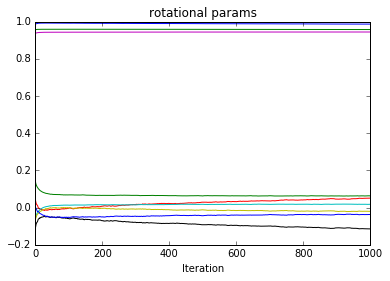

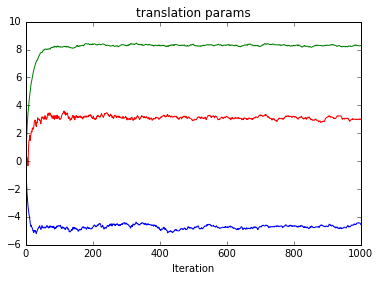

Best trial: 0
-0.208439395445 -0.208526327271
[[ 0.98758161  0.06317046  0.04160075 -4.65064624]
 [ 0.01781307  0.94401212 -0.01862064  8.28087311]
 [-0.10497109 -0.03781922  0.95777868  3.12972343]]


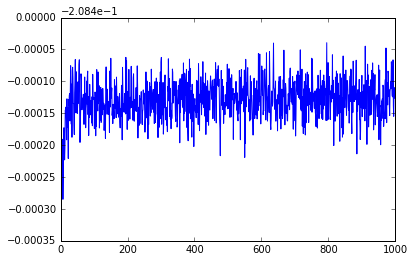

In [341]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [342]:
transform_parameters = {
    'parameters': T_all_trials[best_trial],
    'centroid_m': aligner.centroid_m,
    'centroid_f': aligner.centroid_f,
    'domain_m_origin_wrt_wholebrain': local_aligner_parameters['volume_moving_origin_wrt_wholebrain'],
    'domain_f_origin_wrt_wholebrain': local_aligner_parameters['volume_fixed_origin_wrt_wholebrain']
}

In [343]:
DataManager.save_alignment_results_v2(transform_parameters=transform_parameters,
                       score_traj=scores_all_trials[best_trial],
                       parameter_traj=traj_all_trials[best_trial],
                      alignment_spec=local_alignment_spec)

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_parameters.json" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_parameters.json"
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_scoreHistory.bp"
aws s3 c

In [344]:
volume_moving_tuples = \
        DataManager.load_original_volume_all_known_structures_v2(stack='atlasV5', sided=True, 
                                                              volume_type='score', 
                                                              include_surround=True,
                                                                return_label_mappings=False, 
                                                                 name_or_index_as_key='name',
                                                                 common_shape=False,
                                                                in_bbox_wrt='atlasSpace',
                                                                out_bbox_wrt='atlasSpace',
                                                                structures=['7N_L', '7N_L_surround_200'])

Prior structure/index map not found. Generating a new one.


In [345]:
transform_parameters = DataManager.load_alignment_parameters_v3(alignment_spec=local_alignment_spec)

In [346]:
for name_s, (vol, bbox_wrt_wholebrain) in volume_moving_tuples.iteritems():
#     if convert_to_original_name(name_s) != '7N':
#         continue
    transformed_vol, transformed_vol_box_wrt_fixedWholebrain = transform_volume_by_alignment_parameters(vol, bbox_wrt_wholebrain, transform_parameters=transform_parameters)
    print transformed_vol.shape, transformed_vol_box_wrt_fixedWholebrain
    DataManager.save_transformed_volume(volume=transformed_vol, 
                                        bbox=transformed_vol_box_wrt_fixedWholebrain, 
                                        alignment_spec=local_alignment_spec, 
                                        resolution=None, 
                                        structure=name_s)

Interpolating/filling sparse volume: 0.05 seconds.


(63, 87, 82) [766 852 408 470 178 259]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L_surround_200.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L_surround_200_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/sc

Interpolating/filling sparse volume: 0.03 seconds.


(45, 71, 68) [774 844 416 460 184 251]
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L.bp"
aws s3 cp "/home/yuncong/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32_7N_L_bbox_wrt_fixedWholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume_7N_L_warp27_MD585_prep2_detector15_down32_scoreVolume_7N_down32/score_volumes/atlasV5_down32_scoreVolume_